In [1]:
# TensorFlow and tf.keras

# import tensorflow as tf

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import models
# import tensorflow.keras.utils
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [2]:
data = np.load('/mnt/data/ml/Constituent4vecData1.npz')
evnum = data['jetconstEvnum']
pt = data['jetconstPt']
eta = data['jetconstEta']
phi = data['jetconstPhi']
labels = data['labels']
pt = pt.reshape(336227, 20)
eta = eta.reshape(336227, 20)
phi = phi.reshape(336227, 20)
labels = labels[::20]
fourvec = np.stack((pt,eta,phi), axis = -1)
#ensure same number of signal vs. background and even split of z events
qcd_vec = fourvec[np.where(labels[:,0] == 1)]
if len(qcd_vec) % 3 != 0:
    qcd_vec = qcd_vec[:len(qcd_vec)-(len(qcd_vec) % 3)]
z1_vec = fourvec[np.where(labels[:,1] == 1)]
z1_vec = z1_vec[:int(len(qcd_vec)/3)]
z2_vec = fourvec[np.where(labels[:,2] == 1)]
z2_vec = z2_vec[:int(len(qcd_vec)/3)]
z3_vec = fourvec[np.where(labels[:,3] == 1)]
z3_vec = z3_vec[:int(len(qcd_vec)/3)]
qcd_lab = np.zeros([len(qcd_vec), 2])
qcd_lab[:,0] = 1
z_lab = np.zeros([len(qcd_vec), 2])
z_lab[:,1] = 1
fourvec = np.vstack((qcd_vec, z1_vec, z2_vec, z3_vec))
labels = np.vstack((qcd_lab, z_lab))
print(len(labels), len(fourvec))
#split data into testing/training/validation
n_data = len(fourvec)
testvec = fourvec[::4]
testlabels = labels[::4]
mask_vec = np.ones(fourvec.shape,dtype=bool)
mask_vec[::4] = 0
mask_vec[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0
valvec = fourvec[1::8]
vallabels = labels[1::8]
trainvec = fourvec[mask_vec].reshape((n_data-len(testvec)-len(valvec)),20,3)
trainlabels = labels[mask_lab].reshape((n_data-len(testvec)-len(valvec)), 2)

16540 16540 16540 49620
99240 99240


In [5]:
def build_model():
    input1 = layers.Input(shape = (20,3))
    x = layers.Conv1D(64, 3, padding = 'same', activation='relu')(input1)
    x = layers.Conv1D(64, 1, padding = 'same', activation='relu')(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(32, 3, padding = 'same', activation='relu')(x)
    x = layers.Conv1D(32, 1, padding = 'same', activation='relu')(x)
    x = layers.MaxPool1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
#     x = layers.Dense(256, activation=tf.nn.relu)(x)
#     x = layers.Dense(256, activation=tf.nn.relu)(x)
    output = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inputs=input1, outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

In [6]:
CNN = build_model()

In [7]:
example_batch = trainvec[:10]
example_labels = trainlabels[:10]
example_result = CNN.predict(x = example_batch)
results = CNN.evaluate(x = example_batch, y = example_labels, verbose = 0)
print(example_result)
print(results)

[[8.3337285e-02 9.1666275e-01]
 [1.3237699e-02 9.8676223e-01]
 [8.6547337e-02 9.1345263e-01]
 [4.7100868e-04 9.9952900e-01]
 [1.0208128e-01 8.9791870e-01]
 [6.2867709e-02 9.3713224e-01]
 [1.5991372e-01 8.4008634e-01]
 [2.9329257e-04 9.9970669e-01]
 [1.9772264e-01 8.0227733e-01]
 [1.5472368e-02 9.8452765e-01]]
[3.7723002433776855, 3.7723002433776855, 0.0]


In [8]:
checkpoint_path = "model/CNN1D_v3.h5"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto')    
EPOCHS = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN.fit(
  trainvec, trainlabels,
  epochs=EPOCHS, validation_data = (valvec, vallabels), verbose = 0,
  callbacks=[early_stop, model_checkpoint])

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.59749, saving model to model/CNN1D_v3.h5

Epoch 00002: val_loss improved from 0.59749 to 0.59329, saving model to model/CNN1D_v3.h5

Epoch 00003: val_loss improved from 0.59329 to 0.58961, saving model to model/CNN1D_v3.h5

Epoch 00004: val_loss improved from 0.58961 to 0.54324, saving model to model/CNN1D_v3.h5

Epoch 00005: val_loss improved from 0.54324 to 0.51974, saving model to model/CNN1D_v3.h5

Epoch 00006: val_loss improved from 0.51974 to 0.50506, saving model to model/CNN1D_v3.h5

Epoch 00007: val_loss improved from 0.50506 to 0.49615, saving model to model/CNN1D_v3.h5

Epoch 00008: val_loss improved from 0.49615 to 0.47206, saving model to model/CNN1D_v3.h5

Epoch 00009: val_loss did not improve from 0.47206

Epoch 00010: val_loss improved from 0.47206 to 0.47015, saving model to model/CNN1D_v3.h5

Epoch 00011: val_loss did not improve from 0.47015

Epoch 00012: val_loss improved f

In [9]:
!ls model
best_model = keras.models.load_model('model/CNN1D_v3.h5')
best_model.summary()
results = best_model.evaluate(testvec, testlabels, verbose = 0)
print(results)

CNN1D_v3.h5  CNN_images1.h5  CNN_images.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20, 3)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 20, 64)            640       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 20, 64)            4160      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10, 32)            6176      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 10, 32)            1056      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (Non

In [10]:
predict = best_model.predict(testvec)

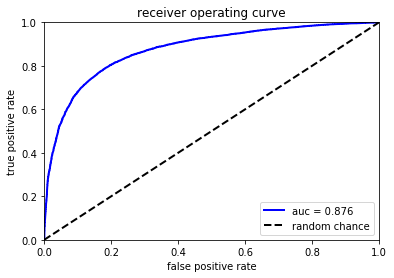

In [11]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels[:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

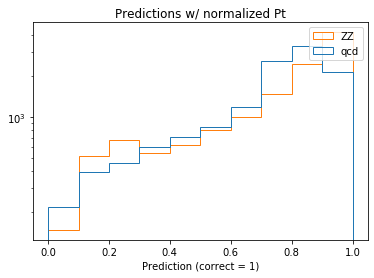

In [12]:
indqcd = np.argwhere(testlabels[:,0] == 1)
indz  = np.argwhere(testlabels[:,1] == 1) 
hist_, bin_edges_ = np.histogram(predict[indqcd])
plt.hist([predict[indqcd, 0].flatten(),predict[indz, 1].flatten()], histtype = 'step', label = ['qcd', 'ZZ'])
plt.legend()
plt.title('Predictions w/ normalized Pt')
plt.yscale('log')
plt.xlabel('Prediction (correct = 1)')
plt.show()